# An OGC API - DGGS visualization client built with DGGAL
This notebook illustrates the use of the [Discrete Global Grid Abstraction Library (DGGAL)](https://dggal.org) to build a basic data visualization client for [OGC API - Discrete Global Grid Systems (DGGS)](https://docs.ogc.org/DRAFTS/21-038r1.html).

## Imports and utility functions

In [1]:
import requests
import urllib
import json
from IPython.display import JSON
from io import BytesIO
import rasterio
from rasterio.plot import show,show_hist
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from shapely.geometry import shape
import geojson
import numpy as np

from dggal import *

from ipyleaflet import Map, basemaps, GeoJSON, Popup
import ipywidgets as widgets

app = Application(appGlobals=globals())
pydggal_setup(app)

def get_call(url, resource):
    call = urllib.parse.urljoin(url, resource)
    #print(f"endpoint: {call}")
    return(requests.get(call))

def post(url, resource, workflow):
    path = urllib.parse.urljoin(url, resource)
    return (requests.post(path, json=workflow))

def findLink(links, rel, lType):
    link = ""
    for key in links:
        if "type" in key:
            if lType in key["type"] and rel in key["rel"]:
              link = key["href"]
              break
    return link

def findCollection(collections, colID):
    for key in collections:
        if colID in key["id"]:
            return key

def displayRGBCoverage(cov, bgcolor, title, axesNames = [ "Longitude", "Latitude" ]):
   fig2, ax2 = plt.subplots(figsize = (7, 7))
   rio = rasterio.open(BytesIO(cov))
   rioCov = rio.read()
   # TODO: Figure out how to set to bgcolor
   #bgArray = np(colors.to_rgb(bgcolor)) / 255.0
   rioCov = np.where(rioCov == -32767, 0.9, np.clip(rioCov / 3500.0, 0.0, 1.0))
   image_hidden2 = ax2.imshow(rioCov.transpose(1, 2, 0), visible=False) #,cmap=cmap,vmin=vmin,vmax=vmax, visible=False)
   extent = image_hidden2.get_extent()
   aspect = abs((extent[1]-extent[0])/(extent[3]-extent[2]))
   ax2.set_xlabel(axesNames[0])
   ax2.set_ylabel(axesNames[1])
   ax2.set_title(title)
   show(rioCov, ax=ax2,transform=rio.transform, interpolation='bilinear', aspect = aspect);

def displayGraduatedCoverage(cov, lvls, clrs, bgcolor, title, axesNames = [ "Longitude", "Latitude" ]):
   vmin = min(lvls)
   vmax = max(lvls)
   norm = colors.Normalize(vmin=vmin, vmax=vmax)  
   normed_vals = norm(lvls)
   cmap = colors.LinearSegmentedColormap.from_list("colormap", list(zip(normed_vals, clrs)), N=1000) 
   cmap.set_under(bgcolor)
   fig2, ax2 = plt.subplots(figsize = (7, 7))
   rio = rasterio.open(BytesIO(cov))
   rioCov = rio.read(1)
   image_hidden2 = ax2.imshow(rioCov,cmap=cmap,vmin=vmin,vmax=vmax, visible=False)
   fig2.colorbar(image_hidden2, ax=ax2, shrink=0.4)
   extent = image_hidden2.get_extent()
   aspect = abs((extent[1]-extent[0])/(extent[3]-extent[2]))
   ax2.set_xlabel(axesNames[0])
   ax2.set_ylabel(axesNames[1])
   ax2.set_title(title)
   show(rioCov,ax=ax2,cmap=cmap,transform=rio.transform, norm=norm,interpolation='bilinear', aspect = aspect);

def calcCentroid(polygonCoordinates):
    polygon = shape({
        "type": "Polygon",
        "coordinates": polygonCoordinates
    })
    centroid = polygon.centroid
    return centroid.y, centroid.x

def setupLeafletMap(center, zoom):
    layout = widgets.Layout(height='600px')
    return Map(center = [ center.y, center.x ],
       scroll_wheel_zoom = True,
       zoom = zoom, interpolation='bilinear', layout=layout, basemap=basemaps.Esri.WorldImagery)
    
def popup_zone_info(map, feature):
   centroid = calcCentroid(feature['geometry']['coordinates'])

   props = feature['properties']
   zoneID = props['zoneID']
   popupText = f"<h3>Zone {zoneID}</h3><table><ul>"
   for key, value in props.items():
      if key != 'style' and key != 'feature::id' and key != 'zoneID': 
         popupText = popupText + f"<tr><td align='right'><b>{key}</b></td><td align='right'><em> {value}</em></td></tr>"
   popupText = popupText + "</ul>"
   popup = Popup(
       location=centroid,
       child=widgets.HTML(popupText),
       auto_close=True
   )
   map.add(popup) #add_layer

def build_style(color, opacity, fillOpacity, weight = 1.0):
   return { 'fillColor': colors.rgb2hex(color), 'fillOpacity': fillOpacity, 'opacity': opacity, 'color': '#FFFFFF', 'weight' : weight }

def color_style(feature, cmap):
   try:
      v = feature["properties"][prop]
      color = cmap((v - vmin) / dv)
      opacity = 1.0
      fillOpacity = 0.85
   except Exception as e:
      color = (0,0,0)
      fillOpacity = 0.0
      opacity = 0.0
   return build_style(color, opacity, fillOpacity)

def s2RGB_style(feature, rgbBands):
   try:
      r = feature["properties"][rgbBands[0]]
      g = feature["properties"][rgbBands[1]]
      b = feature["properties"][rgbBands[2]]

      r = max(0.0, min(1.0, r / 3500))
      g = max(0.0, min(1.0, g / 3500))
      b = max(0.0, min(1.0, b / 3500))
      color = (r, g, b)
      opacity = 0.0 #1.0
      fillOpacity = 1.0 #0.85
   except Exception as e:
      color = (0,0,0)
      fillOpacity = 0.0
      opacity = 0.0
   return build_style(color, opacity, fillOpacity, 0.5)

def displayGraduatedFeatures(map, features, prop, lvls, clrs):
   vmin = min(lvls)
   vmax = max(lvls)
   dv = vmax - vmin
   norm = colors.Normalize(vmin=vmin, vmax=vmax)  
   normed_vals = norm(lvls)
   cmap = colors.LinearSegmentedColormap.from_list("colormap", list(zip(normed_vals, clrs)), N=1000) 
   def zoneStyle(feature):
      return color_style(feature, cmap)
   gjLayer = GeoJSON(data = features, style_callback=zoneStyle)
   map.add(gjLayer) #add_layer
   def on_click_handler(event, feature, **kwargs):
      popup_zone_info(map, feature)
   gjLayer.on_click(on_click_handler)
   return map

def displayS2RGBFeatures(map, features, rgbBands):
   def zoneStyle(feature):
      return s2RGB_style(feature, rgbBands)
   gjLayer = GeoJSON(data = features, style_callback=zoneStyle)
   def on_click_handler(event, feature, **kwargs):
      popup_zone_info(map, feature)
   gjLayer.on_click(on_click_handler)
   map.add(gjLayer)
   return map

tiff = "image/tiff; application=geotiff"

## Configuration

In [2]:
gnosisDemo = 'https://maps.gnosis.earth/ogcapi/' # no auth necessary
# gnosisDemo = 'http://localhost:8080/ogcapi/' # no auth necessary

sloveniaAOI = { "Lat": [ 45.4236367, 46.8639623 ], "Lon": [ 13.3652612, 16.5153015 ] }

bkColor = '#ffe9cc'

## OGC API - Common (discovery, description of capabilities and data)

### Landing page `/`

In [3]:
def requestLandingPage(serverURL):
   return get_call(url = serverURL, resource = "").json()
    
lp = requestLandingPage(gnosisDemo)
JSON(lp)

<IPython.core.display.JSON object>

### Conformance declaration `/conformance`

In [4]:
def requestConformance(serverURL):
   return get_call(url = serverURL, resource = "conformance").json()

conformance = requestConformance(gnosisDemo)
JSON(conformance)

<IPython.core.display.JSON object>

### Data `/collections`

In [5]:
def requestCollections(serverURL):
   return get_call(url = serverURL, resource = "collections").json()
    
cols = requestCollections(gnosisDemo)
s2Id = "sentinel2-l2a"
col = findCollection(cols['collections'], s2Id)

#JSON(cols)
JSON(col)

<IPython.core.display.JSON object>

### Collection description `/collections/{collectionId}`

In [6]:
def requestCollection(serverURL, id):
   return get_call(url = serverURL, resource = f"collections/{id}").json()

s2Col = requestCollection(gnosisDemo, s2Id)
JSON(s2Col)

<IPython.core.display.JSON object>

### Logical Schema `/collections/{collectionId}/schema`

In [7]:
def requestSchema(serverURL, collectionId):
   return get_call(url = serverURL, resource = f"collections/{collectionId}/schema").json()

s2Schema = requestSchema(gnosisDemo, s2Id)
JSON(s2Schema)

<IPython.core.display.JSON object>

## OGC API - DGGS Zone Data requests

[OGC API - DGGS](https://docs.ogc.org/DRAFTS/21-038r1.html) allows to [retrieve data](https://docs.ogc.org/DRAFTS/21-038r1.html#rc_data-retrieval) for a particular DGGRS zone identifier.

If [Custom Depths](https://docs.ogc.org/DRAFTS/21-038r1.html#rc_data-custom-depths) are supported, a `zone-depth` parameter can specify the depth at which data  be retrieved, which determines the number of values in the response.

The examples below are for the [ISEA3H DGGRS](https://docs.ogc.org/DRAFTS/21-038r1.html#isea3h-dggrs), which defines a hierarchy of hexagonal grids with a refinement ratio of 3 on the [ISEA projection](https://proj.org/en/9.4/operations/projections/isea.html).

### As GeoTIFF (relative depth 11):

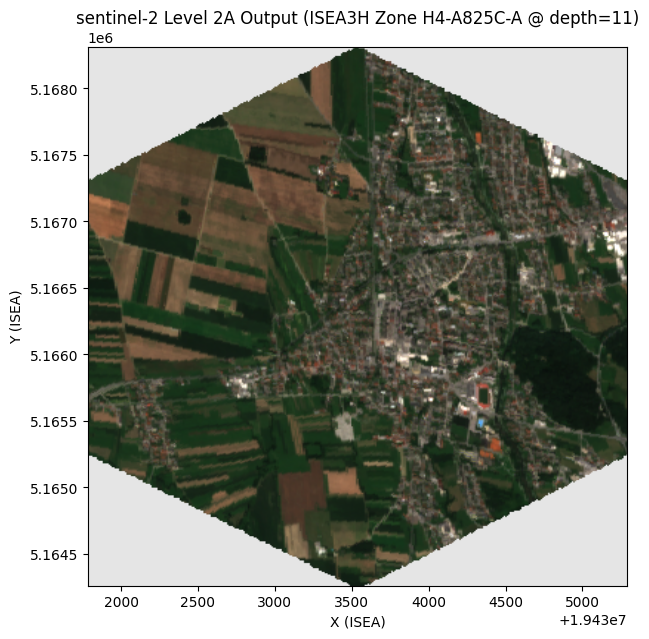

In [8]:
def requestZoneData(serverURL, collectionId, dggrs, zoneId, depth, time, crs, format, fields = None):
   resource = f"collections/{collectionId}/dggs/{dggrs}/zones/{zoneId}/data"
   query = f"?f={format}&zone-depth={depth}&datetime={time}&crs={crs}"
   if fields is not None: query = query + "&properties=" + fields
   return get_call(serverURL, resource + query)

levels = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
clrs = ['#0B0405','#382A54', '#414184', '#3497A9', '#62CFAC', '#DEF5E5']

zoneData = requestZoneData(gnosisDemo, s2Id, "ISEA3H", "H4-A825C-A", 11, "2020-07", "[OGC:1534]", tiff).content
displayRGBCoverage(zoneData, bkColor, "sentinel-2 Level 2A Output (ISEA3H Zone H4-A825C-A @ depth=11)", [ "X (ISEA)", "Y (ISEA)" ])

### As GeoJSON (relative depth 7):

While inefficient, a [GeoJSON](https://docs.ogc.org/DRAFTS/21-038.html#rc_data-geojson) encoding of raster zone data including the geometry of sub-zones facilitates rendering these sub-zones in DGGS-unaware clients.

With the [Jupyter lab leaflet extension](https://ipyleaflet.readthedocs.io/) installed, sub-zones can be clicked to see their identifiers and associated values for each band.

In [9]:
dggrs = ISEA3H()
zoneId = "H4-A825C-A"
zone = dggrs.getZoneFromTextID(zoneId)
centroid = dggrs.getZoneWGS84Centroid(zone)

mapDimensions = Point(1100, 600)

neighbors = dggrs.getZoneNeighbors(zone)
# ipyleaflet doesn't provide map.getBounds().
# This is an experimental guess assuming a WebMercator projection
def computeBBox(c, z):
    dLat = 180 * 1.3 / pow(2, z) * mapDimensions.y / 256
    dLon = 360 / pow(2, z) * mapDimensions.x / 256
    #printLn("dLat: ", dLat, ", dLon: ", dLon)
    return GeoExtent((c[0] - dLat/2, c[1] - dLon/2), (c[0] + dLat/2, c[1] + dLon/2))

# Likely related, it doesn't seem to be possible to set up callbacks for users panning/zooming
# Possibly Voilà (https://voila.readthedocs.io/) allows more interactivity?

fields = "B04,B03,B02,B08"
depth = 7
map = setupLeafletMap(Pointd(centroid.lon, centroid.lat), 13)

bbox = computeBBox(map.center, map.zoom)

#printLn(centroid)
#printLn(bbox)
#if zones != None:
#    print(len(zones), "zones returned")
#    for z in zones:
#        print(dggrs.getZoneTextID(z))

zoneLevel = 14
zones = dggrs.listZones(zoneLevel, bbox)

rgbBands = ['B04', 'B03', 'B02']

i = 1
if zones != None:
   for z in zones:
      zID = dggrs.getZoneTextID(z)
      printLn("Fetching ", zID, " (", i, " / ", len(zones), ")")
      i += 1
      geoJSONZoneData = requestZoneData(gnosisDemo, s2Id, "ISEA3H", zID, depth, "2020-07", "[OGC:CRS84]", "geojson", fields).json()
      displayS2RGBFeatures(map, geoJSONZoneData, rgbBands)   

# This requests a single zone:
#geoJSONZoneData = requestZoneData(gnosisDemo, s2Id, "ISEA3H", zoneId, depth, "2020-07", "[OGC:CRS84]", "geojson").json()
#displayS2RGBFeatures(map, geoJSONZoneData, rgbBands)

# This requests the immediate neighbors of a zone:
#for n in neighbors:
#   nID = dggrs.getZoneTextID(n)
#   geoJSONZoneData = requestZoneData(gnosisDemo, s2Id, "ISEA3H", nID, depth, "2020-07", "[OGC:CRS84]", "geojson").json()
#   displayS2RGBFeatures(map, geoJSONZoneData, rgbBands)

map


Fetching H4-A68BA-A (1 / 17)
Fetching H4-A7144-A (2 / 17)
Fetching H4-A7145-A (3 / 17)
Fetching H4-A7146-A (4 / 17)
Fetching H4-A79CF-A (5 / 17)
Fetching H4-A79D0-A (6 / 17)
Fetching H4-A79D1-A (7 / 17)
Fetching H4-A825B-A (8 / 17)
Fetching H4-A825C-A (9 / 17)
Fetching H4-A825D-A (10 / 17)
Fetching H4-A8AE7-A (11 / 17)
Fetching H4-A8AE8-A (12 / 17)
Fetching H4-A8AE9-A (13 / 17)
Fetching H4-A9372-A (14 / 17)
Fetching H4-A9373-A (15 / 17)
Fetching H4-A9374-A (16 / 17)
Fetching H4-A9BFE-A (17 / 17)


Map(center=[46.14072467828475, 14.590937410412764], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [10]:
def requestZoneInfo(serverURL, collectionId, dggrs, zoneId, format):
   resource = f"collections/{collectionId}/dggs/{dggrs}/zones/{zoneId}?f={format}"
   return get_call(serverURL, resource)

# zoneInfo = requestZoneInfo(gnosisDemo, s2Id, "ISEA3H", zoneId, "geojson").json()
# center = shape(zoneInfo["features"][0]["geometry"]).centroid

### As DGGS-JSON (relative depth 7):

[DGGS-JSON](https://docs.ogc.org/DRAFTS/21-038.html#rc_data-json) is an encoding specifically targeting DGGS-enabled clients, allowing to return data values quantized to sub-zones while relying on the client's understanding of the DGGRS and a deterministic order of sub-zones. Here we use DGGAL to automatically generate GeoJSON from the DGGS-JSON to add it as a GeoJSON layer to Leaflet.

In [11]:
depth = 7
zoom = 15 #13
map = setupLeafletMap(Pointd(centroid.lon, centroid.lat), zoom)

bbox = computeBBox(map.center, map.zoom)

zoneLevel = dggrs.getLevelFromPixelsAndExtent(bbox, mapDimensions, dggrs.get64KDepth()+1)
# printLn("Selected level: ", zoneLevel)
zones = dggrs.listZones(zoneLevel, bbox)

def generateZoneGeometry(dggrs, zone, crs, id, centroids: bool, fc: bool):
   coordinates = []
   if not crs or crs == CRS(ogc, 84) or crs == CRS(epsg, 4326):
      if centroids:
         centroid = dggrs.getZoneWGS84Centroid(zone, centroid)
         coordinates.append(centroid.lon.value)
         coordinates.append(centroid.lat.value)
      else:
         vertices = dggrs.getZoneRefinedWGS84Vertices(zone, 0)
         if vertices:
            contour = [ ]
            for v in vertices:
               contour.append([ v.lon.value, v.lat.value])
            contour.append([vertices[0].lon.value, vertices[0].lat.value])
            coordinates.append(contour)
   else:
      if centroids:
         centroid = dggrs.getZoneCRSCentroid(zone, crs, centroid)
         coordinates.append(centroid.x)
         coordinates.append(centroid.y)
      else:
         vertices = dggrs.getZoneRefinedCRSVertices(zone, crs, 0)
         if vertices:
            count = vertices.count
            contour = [ ]
            for v in vertices:
               contour.append([v.x, v.y])
            contour.append([vertices[0].x, vertices[0].y])
            coordinates.append(contour)
   geometry = {
      'type': 'Point' if centroids else 'Polygon',
      'coordinates': coordinates
   }
   return geometry

def generateZoneFeature(dggrs, zone, crs, id, centroids: bool, fc: bool, props):
   zoneID = dggrs.getZoneTextID(zone)

   properties = {
      'zoneID': f'{zoneID}'
   }
   if props:
      for key, v in props.items():
         properties[key] = v

   features = {
      'type': 'Feature',
      'id': id if id is not None else zoneID,
      'geometry': generateZoneGeometry(dggrs, zone, crs, id, centroids, fc),
      'properties': properties
   }
   return features

def dggsJSON2GeoJSON(dggsJSON, crs: CRS = None, centroids: bool = False):
   result = None
   if dggsJSON is not None:
         dggrsClass = None
         dggrsID = getLastDirectory(dggsJSON['dggrs'])

         # We could use globals()['GNOSISGlobalGrid'] to be more generic, but here we limit to DGGRSs we know
         if   not strnicmp(dggrsID, "GNOSIS", 6): dggrsClass = GNOSISGlobalGrid
         elif not strnicmp(dggrsID, "ISEA3H", 6): dggrsClass = ISEA3H
         elif not strnicmp(dggrsID, "ISEA9R", 6): dggrsClass = ISEA9R
         elif not strnicmp(dggrsID, "IVEA3H", 6): dggrsClass = IVEA3H
         elif not strnicmp(dggrsID, "IVEA9R", 6): dggrsClass = IVEA9R

         if dggrsClass:
            zoneID = dggsJSON['zoneId']
            dggrs = dggrsClass()
            zone = dggrs.getZoneFromTextID(zoneID)

            if zone != nullZone:
                depths = dggsJSON['depths']
                if depths:
                  maxDepth = -1

                  for d in range(len(depths)):
                     depth = depths[d]
                     if depth > maxDepth:
                        maxDepth = depth
                        break;
                  if d < len(depths):
                     depth = maxDepth
                     subZones = dggrs.getSubZones(zone, depth)
                     if subZones:
                        i = 0
                        values = dggsJSON['values']
                        features = [ ]
                        for z in subZones:
                           props = { }
                           for key, vDepths in values.items():
                              if key and vDepths and len(vDepths) > d:
                                 data = vDepths[d]['data']
                                 props[key] = data[i]
                           features.append(generateZoneFeature(dggrs, z, crs, i + 1, centroids, True, props))
                           i += 1
                        result = {
                           'type': 'FeatureCollection',
                           'features': features
                        }
   return result

if zones != None:
   i = 1
   for z in zones:
      zID = dggrs.getZoneTextID(z)
      printLn("Fetching ", zID, " (", i, " / ", len(zones), ")")
      i += 1
      dggsjsonZoneData = requestZoneData(gnosisDemo, s2Id, "ISEA3H", zID, depth, "2020-07", "[OGC:CRS84]", "json", fields).json()
      geoJSONZoneData = dggsJSON2GeoJSON(dggsjsonZoneData)
      #print(json.dumps(geoJSONZoneData, indent = 3))
      displayS2RGBFeatures(map, geoJSONZoneData, rgbBands)

map


Fetching I4-5E1924-A (1 / 13)
Fetching I4-5E32C5-A (2 / 13)
Fetching I4-5E4C65-A (3 / 13)
Fetching I4-5E4C66-A (4 / 13)
Fetching I4-5E4C67-A (5 / 13)
Fetching I4-5E6607-A (6 / 13)
Fetching I4-5E6608-A (7 / 13)
Fetching I4-5E6609-A (8 / 13)
Fetching I4-5E7FA9-A (9 / 13)
Fetching I4-5E7FAA-A (10 / 13)
Fetching I4-5E7FAB-A (11 / 13)
Fetching I4-5E994B-A (12 / 13)
Fetching I4-5EB2EC-A (13 / 13)


Map(center=[46.14072467828475, 14.590937410412764], controls=(ZoomControl(options=['position', 'zoom_in_text',…